<a href="https://colab.research.google.com/github/MendeBadra/chimege_tts/blob/main/TextToSpeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers==4.48.0 soundfile speechbrain accelerate

  Using cached transformers-4.48.0-py3-none-any.whl.metadata (44 kB)
  Using cached speechbrain-1.0.3-py3-none-any.whl.metadata (24 kB)
  Using cached HyperPyYAML-1.2.2-py3-none-any.whl.metadata (7.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidi

In [ ]:
pip install "datasets<=3.6.0"

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset, Audio

# Load the Mongolian split ("mn") of Common Voice (you can also use train/validation/test subsets)
dataset = load_dataset("mozilla-foundation/common_voice_17_0", "mn", split="train+validation+test")

# Audioload info
len(dataset), dataset.column_names


(5941,
 ['client_id',
  'path',
  'audio',
  'sentence',
  'up_votes',
  'down_votes',
  'age',
  'gender',
  'accent',
  'locale',
  'segment',
  'variant'])

In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
# checkpoint = "techiaith/microsoft_speecht5_finetuned_bu_tts_cy_en"
# checkpoint = "voxxer/speecht5_finetuned_commonvoice_ru_translit"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [ ]:
tokenizer = processor.tokenizer

In [ ]:
dataset[0]

{'client_id': '4ed94b81ab0b739f95d3869cafe4629152f3c7a4c2cf12ffb437e6d474f08f2f71410fa1cc27f8d8e6acab0ac118bddf958e7b59bcd133c1cc54691ca785d431',
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/ea55f4bcf34bee825858b4004b899cc3f61aa2ae6f62457d7d74937f1791c2ac/mn_train_0/common_voice_mn_18578097.mp3',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/ea55f4bcf34bee825858b4004b899cc3f61aa2ae6f62457d7d74937f1791c2ac/mn_train_0/common_voice_mn_18578097.mp3',
  'array': array([ 9.09494702e-12, -2.27373675e-13,  5.45696821e-12, ...,
         -5.22854862e-06, -1.21556368e-05, -9.76262163e-06]),
  'sampling_rate': 16000},
 'sentence': 'Мань хүн бүсгүйн гараас аягыг нь авч ширээн дээр тавив.',
 'up_votes': 2,
 'down_votes': 0,
 'age': 'twenties',
 'gender': 'male_masculine',
 'accent': '',
 'locale': 'mn',
 'segment': '',
 'variant': ''}

In [ ]:
import re

def normalize_text(example):
    sentence = example["sentence"]
    # Convert to lowercase and remove punctuation
    normalized = re.sub(r"[^\w\s]", "", sentence.lower())
    return {"normalized_text": normalized}

# Apply the normalization function to the dataset
dataset = dataset.map(normalize_text)

# Display a sample to verify
print(dataset[0]["normalized_text"])

мань хүн бүсгүйн гараас аягыг нь авч ширээн дээр тавив


In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/5941 [00:00<?, ? examples/s]

In [ ]:
dataset_vocab - tokenizer_vocab

{' ',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 'ү',
 'ө'}

In [ ]:
replacements = [
    ("а", "a"),
    ("б", "b"),
    ("в", "v"),
    ("г", "g"),
    ("д", "d"),
    ("е", "e"),
    ("ё", "yo"),
    ("ж", "zh"),
    ("з", "z"),
    ("и", "i"),
    ("й", "y"),
    ("к", "k"),
    ("л", "l"),
    ("м", "m"),
    ("н", "n"),
    ("о", "o"),
    ("п", "p"),
    ("р", "r"),
    ("с", "s"),
    ("т", "t"),
    ("у", "u"),
    ("ф", "f"),
    ("х", "kh"),   # or "h"
    ("ц", "ts"),
    ("ч", "ch"),
    ("ш", "sh"),
    ("ъ", ""),     # hard sign, usually omitted in transliteration
    ("ы", "y"),
    ("ь", ""),     # soft sign, also often omitted
    ("э", "e"),
    ("ю", "yu"),
    ("я", "ya"),
    ("ү", "ü"),
    ("ө", "ö"),
    (" ", " ")
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/tmp/speechbrain/spkrec-xvect-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in /tmp/speechbrain/spkrec-xvect-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ck

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [ ]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [ ]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

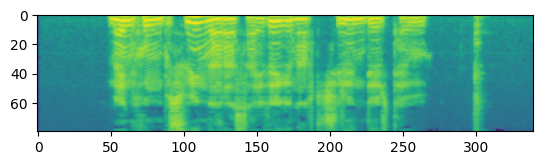

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/5941 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)


In [ ]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [ ]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [86]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_common_voice_mon",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True, # Change this to False
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [87]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/tmp/ipython-input-1231872571.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
1000,0.542500,0.498644
2000,0.516200,0.476018
3000,0.508900,0.469470


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [ ]:
trainer.push_to_hub()

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained(
    "mendeeb/speecht5_finetuned_common_voice_mon"
)

In [ ]:
example = dataset["test"][304]
# Ensure speaker_embeddings is a torch tensor and cast to float16 if model is in fp16
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

# Check model dtype and cast speaker_embeddings accordingly
if hasattr(model, 'dtype') and model.dtype == torch.float16:
     speaker_embeddings = speaker_embeddings.to(torch.float16)
elif hasattr(model.config, 'torch_dtype') and model.config.torch_dtype == torch.float16:
    speaker_embeddings = speaker_embeddings.to(torch.float16)
# Add other checks if necessary based on how the model's dtype is stored

# Move to the same device as the model
if hasattr(model, 'device'):
    speaker_embeddings = speaker_embeddings.to(model.device)

In [ ]:
# text = "Тэр жил зун орой тосгонд байхад минь, бидний суудаг байшингаас гол, голын цаадтай тэгш тал, алсын уулс харагдаж, голын сайр хайрга дайргаар дүүрээд, наранд цайран хуурай дааж, устай газраа түргэн урсгалтай, тунгалаг, цэв цэнхэр байлаа.\
#  Байшингийн дэргэдүүрх замаар цувж байгаа цэргийн хөлөөр боссон тоос модны навчсыг хучна. \
#  Модны иш аанай л тоосонд дарагдан, тэр жил навчис эрт унаж эхэлсэн бөгөөд замаар цэрэг явах, тоос манарах\
#  , салхинд үлээгдсэн навчис унахыг бид ажиглан, цэргүүд алхалж өнгөрөхөд хувхай цагаан навчис л зам дээр үлддэг сэн"

text = "Can avoid issues due to different operating systems, as Docker provides a consistent system."

# text = "Hi! How are you? Do you know about n8n?"

In [ ]:
inputs = processor(text=text, return_tensors="pt")

In [ ]:
from transformers import SpeechT5HifiGan
import torch # Import torch

# Determine the device
device = "cuda" if torch.cuda.is_available() else "cpu"

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device) # Move vocoder to device

# Ensure model is on the correct device (it should be if loaded after trainer init, but explicitly move it)
model.to(device)

# Move input_ids to the same device
inputs["input_ids"] = inputs["input_ids"].to(device)

# speaker_embeddings is already moved to model.device in cell y7_Y24fjNWYS

speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [ ]:
from IPython.display import Audio

Audio(speech.cpu(), rate=16000)

In [ ]:
import transformers
transformers.__version__

'4.48.0'